Runs the TransE model on the knowledge graph obtained to recover and visualize the embeddings of the nhEvent knowledge extracted. 

Heavily inspired by https://www.youtube.com/watch?v=WlVa52xP-ug

In [7]:
import pandas as pd
import numpy as np
import pylab as plt
import torch.optim as optim
import torch
from copy import deepcopy
from src.models import transE
from src.utils import getBatchList, getBatch


In [4]:
kg_df = pd.read_excel('data/nhEvent_kg_df.xlsx')

In [5]:
data = []
for _, row in kg_df.iterrows():
    h = row['source']
    r = row['edge']
    t = row['target']
    data.append((h, r, t))

entityDic={k:n for n,k in enumerate(set([j for i in data for j in [i[0],i[-1]]]))}
relationDic={k:n for n,k in enumerate(set([i[1] for i in data]))}
entityDic_={k:n for n,k in entityDic.items()}
relationDic_={k:n for n,k in relationDic.items()}


In [6]:

category_Entity_Dic = {}
for key in entityDic:
    source_ent = kg_df[kg_df['source'] == key]
    target_ent = kg_df[kg_df['target'] == key]
    if source_ent.shape[0] > 0:
        category_Entity_Dic[key] = source_ent['category'].unique().tolist()
    if target_ent.shape[0] > 0:
        if key in category_Entity_Dic:
            category_Entity_Dic[key].extend(target_ent['category'].unique().tolist())
        else:
            category_Entity_Dic[key] = target_ent['category'].unique().tolist()


category_Relation_Dic = {}
for key in relationDic:
    relation = kg_df[kg_df['edge'] == key]
    category_Relation_Dic[key] = relation['category'].unique().tolist()



In [43]:
# quick check:
# this example does not really make sense as an earthquake, 
# hence the need for improved data prep! 
kg_df[kg_df['edge'] == 'blew across southern']

,source,target,edge,category
1572,dense cloud,southern Pacific September,blew across southern,['Earthquakes']


In [8]:


entity_size=len(entityDic)
relation_size=len(relationDic)
embedding_size=2
triples= [(entityDic[i],relationDic[j],entityDic[k]) for i,j,k in data]
nBatch=10
trainBatchList=getBatchList(triples, nBatch)
transe = transE(entity_size, relation_size, embedding_size)

# training
num_epochs = 1000
learning_rate = 0.001
optimizer = optim.Adam(transe.parameters(), lr=learning_rate)
Loss=[]
posEnData={}
posReData={}
for epo in range(num_epochs):
    total_loss = 0
    for batchList in trainBatchList:
        optimizer.zero_grad()
        pos_h_batch, pos_r_batch, pos_t_batch, neg_h_batch,neg_r_batch, neg_t_batch=getBatch(batchList,entity_size)
        pos_h_batch = torch.LongTensor(pos_h_batch)
        pos_t_batch = torch.LongTensor(pos_t_batch)
        pos_r_batch = torch.LongTensor(pos_r_batch)
        neg_h_batch = torch.LongTensor(neg_h_batch)
        neg_t_batch = torch.LongTensor(neg_t_batch)
        neg_r_batch = torch.LongTensor(neg_r_batch)
        
        loss = transe(pos_h_batch, pos_r_batch, pos_t_batch, neg_h_batch,neg_r_batch, neg_t_batch)
    
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    if epo % 100 == 0:    
        print(f'Loss at epo {epo}: {total_loss/len(triples)}')# print average loss within an epoch
    posEnData[epo]=deepcopy(transe.W_en.weight.data.numpy()) #dictioanry of positive entity embedding, key:epo, value:embedding
    posReData[epo]=deepcopy(transe.W_re.weight.data.numpy())#dictioanry of positive relation embedding, key:epo, value:embedding
    Loss.append(total_loss/len(triples))



Loss at epo 0: 6.019544320028336
Loss at epo 100: 2.531339379607654
Loss at epo 200: 1.1204806155845768
Loss at epo 300: 0.49215738108900725
Loss at epo 400: 0.20907032294351546
Loss at epo 500: 0.08516638493928753
Loss at epo 600: 0.03357155853119053
Loss at epo 700: 0.01309356685788905
Loss at epo 800: 0.005164437515080952
Loss at epo 900: 0.002087288009399762


Text(0, 0.5, 'Loss')

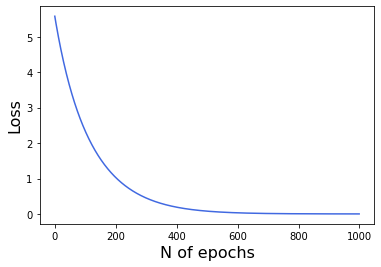

In [39]:

plt.plot(Loss,color='RoyalBlue',marker='')
plt.xlabel('N of epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)

In [14]:
epo=999
posEn=dict(zip(entityDic_.values(),posEnData[epo]))
posRe=dict(zip(relationDic_.values(),posReData[epo]))


In [42]:
posEn['Areas']

array([ 0.51904124, -0.73253006], dtype=float32)

In [9]:
sample = kg_df.sample(n=1)

In [63]:
abs(posEn['global  temperatures'] + posRe['parched many'] - posEn['many  states']).sum()

1.5616417e-05

In [65]:
abs(posEn['global  temperatures'] + posRe['parched many'] - posEn['like  phytoplankton']).sum()

2.7449846

In [18]:
abs(posEn[sample['source'].values[0]] + posRe[sample['edge'].values[0]] -
                 posEn[sample['target'].values[0]]).sum()

0.0016376078

Really want to emphasize proof of concept here, but again our knowledge is in agreement with this result, where phytoplankton is a concept unrelated to how global temperatures are leading to parching many, and we see how it is further in the embedding space from the true relation, which are 'many states'. 

If we wanted to further visualize the embeddings, an essential prequisite before doing so would be to classify entities properly, could possibly use the metadata provided by NASA regarding what "topic" this is, but an additional tool for classifiying entities may be insightful. I would consider such steps along with other notes along the way very important before bringing this to more eyes, but this is how you can start to construct a knowledge graph out of the data contained within the articles and metadata provided by NASA Earth Observatory. 